# 1. 데이터 & 라이브러리 준비

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
import pandas as pd
from scipy.signal import butter, filtfilt, hilbert, stft
import torch

A4_origin.wav 파일은 https://www.yamaha.com/en/musical_instrument_guide/piano/mechanism/mechanism004.html 에서 다운받았습니다.

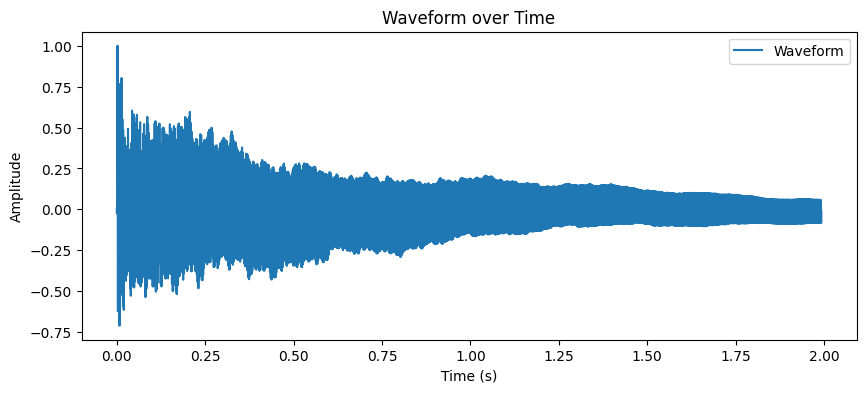

In [53]:
rate, data = wavfile.read('A4_origin.wav')

if data.ndim > 1:
    data = np.mean(data, axis=1)
data = data / np.max(np.abs(data))

start_time = 0.188
end_time = 2.18

start_sample = int(start_time * rate)
end_sample = int(end_time * rate)

data = data[start_sample:end_sample]

duration = len(data)/rate
t = np.linspace(0, duration, num=len(data), endpoint=False)

plt.figure(figsize=(10, 4))
plt.plot(t, data, label="Waveform")
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform over Time')
plt.legend()
plt.show()

# 2. 원본 데이터

### (1) Short time Fourier transform spectogram

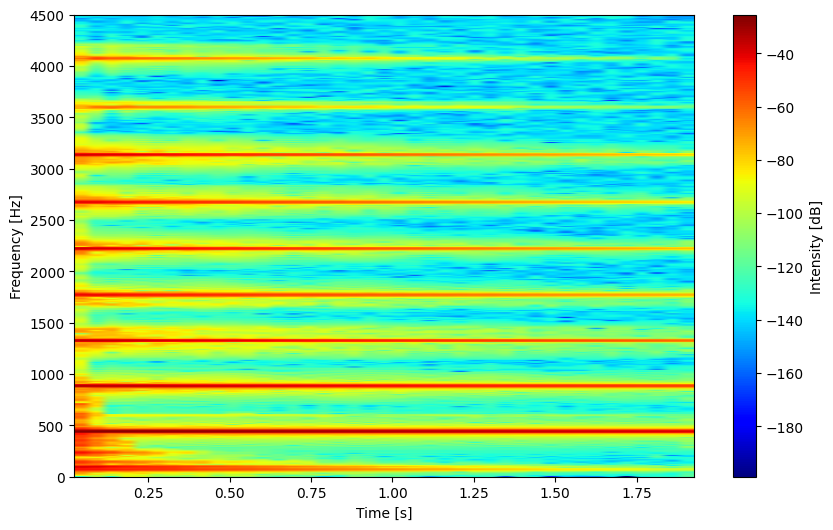

In [54]:
nfft = 1024
noverlap = 512

plt.figure(figsize=(10, 6))
plt.specgram(data, NFFT=nfft, Fs=rate, noverlap=noverlap, cmap='jet')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Intensity [dB]')
plt.ylim(0, 4500)
plt.show()

### (2) 각 주파수 성분의 초기 진폭, 감쇠 계수, 위상 각도 측정

중심 주파수를 주변으로 bandwidth(Hz) 크기의 폭을 갖는 필터를 적용하여 특정 주파수대만 추출하는 함수

In [55]:
def bandpass_filter(data, fs, center_freq, bandwidth=20, order=2):
    nyquist = 0.5 * fs
    low = (center_freq - bandwidth/2) / nyquist
    high = (center_freq + bandwidth/2) / nyquist

    low = max(low, 1e-6)
    high = min(high, 0.999999)

    b, a = butter(order, [low, high], btype='band')
    filtered_data = filtfilt(b, a, data)
    return filtered_data

초기 진폭과 감쇠 계수를 계산하는 함수

In [56]:
def estimate_amplitude_and_damping(time, signal_envelope):
    env_log = np.log(signal_envelope + 1e-12)

    p = np.polyfit(time, env_log, 1)

    b = -p[0]
    A = np.exp(p[1])

    return A, b

특정 주파수대역 별 속성값 계산

In [57]:
frequencies = [440, 881, 1342, 1769, 2219, 2673, 3133, 3599, 4072]
results = []

for i, freq in enumerate(frequencies):
    filtered = bandpass_filter(data, rate, center_freq=freq, bandwidth=20, order=2)

    analytic_signal = hilbert(filtered)
    envelope = np.abs(analytic_signal)

    initial_phase = np.angle(analytic_signal[0])

    A, b = estimate_amplitude_and_damping(t, envelope)

    if i == 0:
        harmonic_type = "Fundamental"
    else:
        harmonic_type = f"Harmonic {i}"

    results.append({
        "Type": harmonic_type,
        "Frequency(Hz)": freq,
        "Initial Amplitude": A,
        "Damping Coefficient": b,
        "Phase angle (rad)": initial_phase
    })

df = pd.DataFrame(results)
df

,Type,Frequency(Hz),Initial Amplitude,Damping Coefficient,Phase angle (rad)
0,Fundamental,440,0.335648,0.855145,-0.621275
1,Harmonic 1,881,0.143129,1.248606,-0.625736
2,Harmonic 2,1342,0.009829,1.618150,-0.715088
3,Harmonic 3,1769,0.058574,2.042331,1.075674
4,Harmonic 4,2219,0.094736,2.518472,1.865744
5,Harmonic 5,2673,0.064923,2.675828,2.864683
6,Harmonic 6,3133,0.095200,2.719635,2.685549
7,Harmonic 7,3599,0.007860,3.337338,0.940088
8,Harmonic 8,4072,0.013892,3.851166,-2.243742


### (3) 3차원 시각화

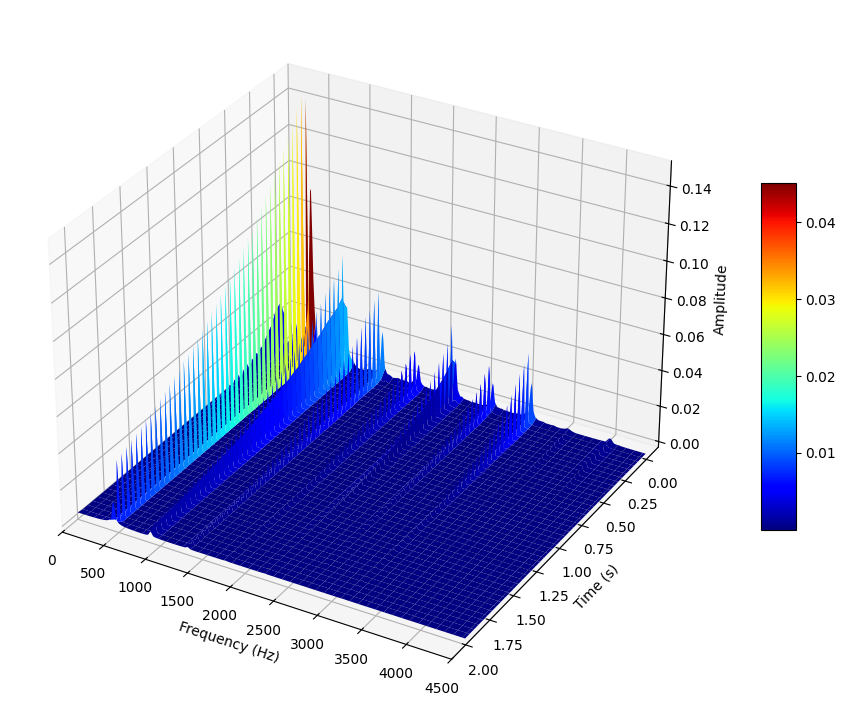

In [58]:
freqs, times, Zxx = stft(data, fs=rate, nperseg=nfft)
amplitude = np.abs(Zxx)

freq_mask = freqs <= 4500
freqs = freqs[freq_mask]
amplitude = amplitude[freq_mask, :]

time_mask = times <= 2
times = times[time_mask]
amplitude = amplitude[:, time_mask]

T, F = np.meshgrid(times, freqs)

fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(F, T, amplitude, cmap='jet')

ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Time (s)')
ax.set_zlabel('Amplitude')
ax.set_xlim([0, 4500])
ax.invert_yaxis()

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
plt.show()

# 3. Damping Coefficient 최적화

### (1) Damping 효과 적용하지 않은 오디오 생성

In [73]:
def generate_piano_sound(fs, tn, a, omega):
    t = np.arange(0, tn, 1/fs)
    n = len(a)
    y = np.zeros(len(t))
    for i in range(n):
        y += a[i] * np.sin(2 * np.pi * omega[i] * t)
    y *= 15
    wavfile.write('A4_no_damping.wav', fs, y.astype(np.float32))

fs = rate
tn = len(data) / rate
a = [0.0371, 0.01429, 0.0004265, 0.006342, 0.01083, 0.004259, 0.01178, 0.00022, 0.00037]
omega = [440, 881, 1342, 1769, 2219, 2673, 3133, 3599, 4072]
generate_piano_sound(fs, tn, a, omega)

Sampling rate: 11025 Hz, 데이터 길이: (21962,)


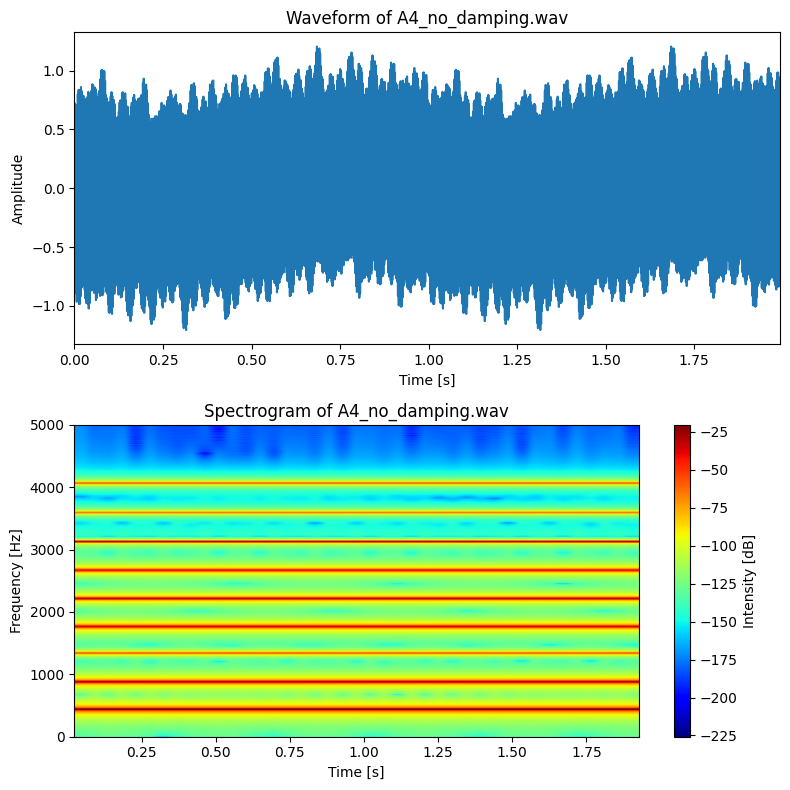

In [96]:
fs, data_no_damp = wavfile.read("A4_no_damping.wav")
print(f"Sampling rate: {fs} Hz, 데이터 길이: {data_no_damp.shape}")

if data_no_damp.ndim > 1:
    data_no_damp = data[:, 0]

t = np.linspace(0, len(data_no_damp) / fs, num=len(data_no_damp))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(t, data_no_damp)
plt.title('Waveform of A4_no_damping.wav')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.xlim(0, t[-1])

plt.subplot(2, 1, 2)
plt.specgram(data_no_damp, Fs=fs, NFFT=nfft, noverlap=noverlap, cmap='jet')
plt.title('Spectrogram of A4_no_damping.wav')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Intensity [dB]')
plt.ylim(0, 5000)
plt.tight_layout()
plt.show()

### (2) Damping Coefficient 학습

In [97]:
num_samples = len(data)
t = torch.linspace(0, tn, steps=num_samples, dtype=torch.float32)

a = torch.tensor(a, dtype=torch.float32)
omega = torch.tensor(omega, dtype=torch.float32)
damping = torch.nn.Parameter(torch.full((len(a),), 0.1, dtype=torch.float32))

target_audio = torch.tensor(data, dtype=torch.float32)

optimizer = torch.optim.Adam([damping], lr=1e-2)
num_epochs = 1500

for epoch in range(num_epochs):
    optimizer.zero_grad()

    y_pred = 0.0
    for i in range(len(a)):
        y_pred = y_pred + a[i] * torch.exp(-damping[i] * t) * torch.sin(2 * np.pi * omega[i] * t)
    y_pred *= 15

    loss = torch.mean((y_pred - target_audio)**2)

    loss.backward()
    optimizer.step()

    damping.data.clamp_(min=0)

    if (epoch+1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.6f}")

generated_audio = y_pred.detach().numpy()
wavfile.write('A4_with_damping.wav', fs, generated_audio.astype(np.float32))

<ipython-input-97-dfe274a09897>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(a, dtype=torch.float32)
<ipython-input-97-dfe274a09897>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  omega = torch.tensor(omega, dtype=torch.float32)


Epoch 100/1500, Loss: 0.087619
Epoch 200/1500, Loss: 0.065525
Epoch 300/1500, Loss: 0.055799
Epoch 400/1500, Loss: 0.050123
Epoch 500/1500, Loss: 0.046324
Epoch 600/1500, Loss: 0.043565
Epoch 700/1500, Loss: 0.041449
Epoch 800/1500, Loss: 0.039762
Epoch 900/1500, Loss: 0.038377
Epoch 1000/1500, Loss: 0.037214
Epoch 1100/1500, Loss: 0.036220
Epoch 1200/1500, Loss: 0.035357
Epoch 1300/1500, Loss: 0.034600
Epoch 1400/1500, Loss: 0.033927
Epoch 1500/1500, Loss: 0.033324


In [98]:
results = []

for i, (freq, A, b) in enumerate(zip(omega.data.numpy(), a.data.numpy(), damping.data.numpy())):
    if i == 0:
        harmonic_type = "Fundamental"
    else:
        harmonic_type = f"Harmonic {i}"

    results.append({
        "Type": harmonic_type,
        "Frequency(Hz)": freq,
        "Initial Amplitude": A,
        "Damping Coefficient": b,
    })

df = pd.DataFrame(results)
df

,Type,Frequency(Hz),Initial Amplitude,Damping Coefficient
0,Fundamental,440.0,0.037100,3.511589
1,Harmonic 1,881.0,0.014290,2.654186
2,Harmonic 2,1342.0,0.000426,3.491330
3,Harmonic 3,1769.0,0.006342,3.992490
4,Harmonic 4,2219.0,0.010830,4.089514
5,Harmonic 5,2673.0,0.004259,3.861232
6,Harmonic 6,3133.0,0.011780,4.000175
7,Harmonic 7,3599.0,0.000220,4.540738
8,Harmonic 8,4072.0,0.000370,1.891441


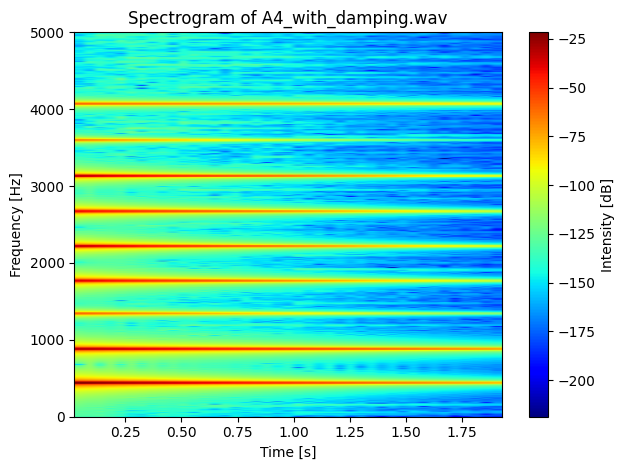

In [99]:
f, t, Zxx = stft(generated_audio, fs=fs, window='hann', nperseg=nfft, noverlap=noverlap)

plt.specgram(generated_audio, Fs=fs, NFFT=nfft, noverlap=noverlap, cmap='jet')
plt.title('Spectrogram of A4_with_damping.wav')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.colorbar(label='Intensity [dB]')
plt.ylim(0, 5000)
plt.tight_layout()
plt.show()

### (3) 원본 데이터와의 비교

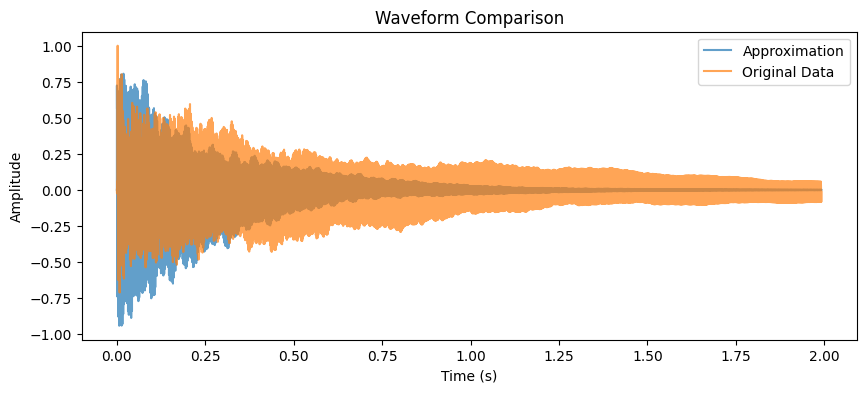

In [100]:
t = torch.linspace(0, tn, steps=num_samples, dtype=torch.float32)

plt.figure(figsize=(10, 4))
plt.plot(t, generated_audio, label="Approximation", alpha=0.7)
plt.plot(t, data, label="Original Data", alpha=0.7)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Waveform Comparison')
plt.legend()
plt.show()

# 4. STFT of "Twinkle Twinkle little star"

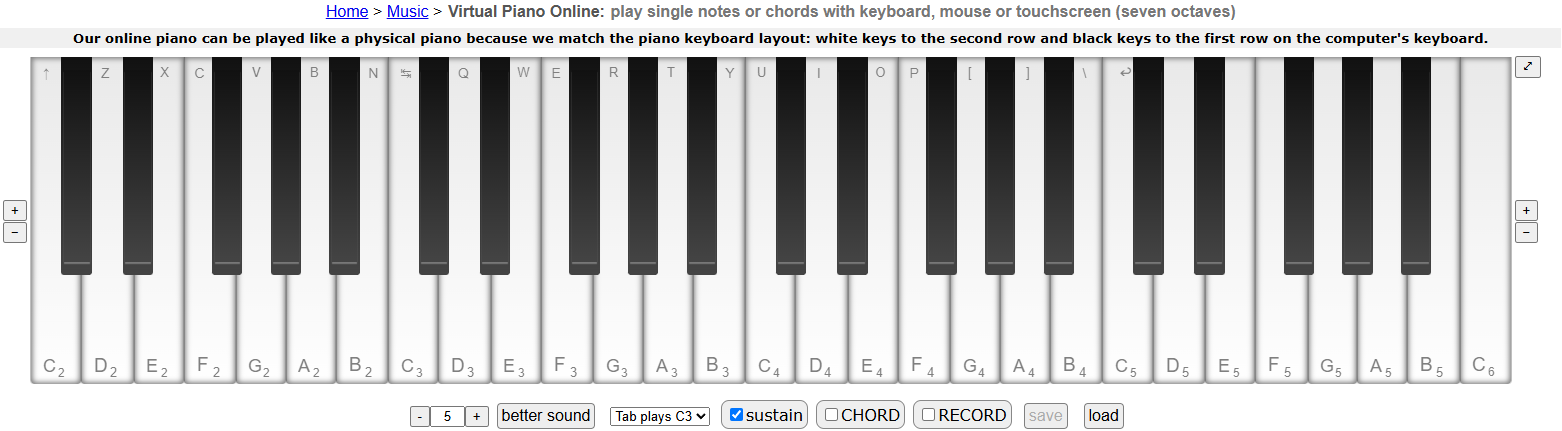

Twinkle.wav 파일은 https://www.apronus.com/music/flashpiano.htm 에서 녹음하였습니다.

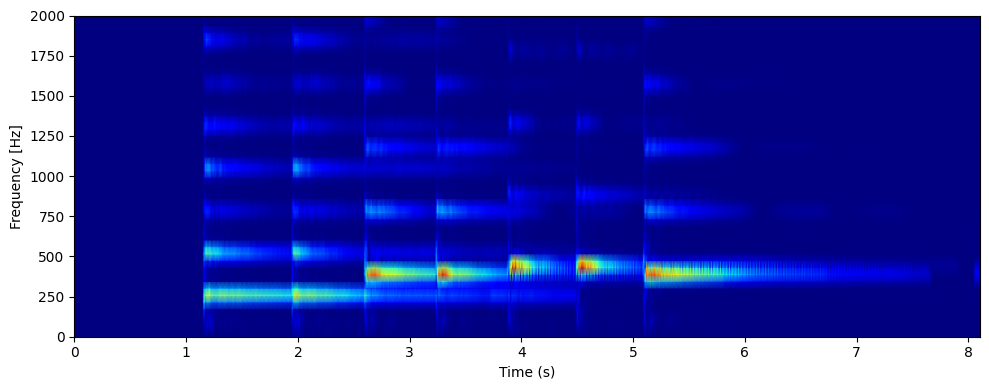

In [94]:
fs, song = wavfile.read('Twinkle.wav')

if song.ndim > 1:
    song = song[:, 0]

nperseg = 1024
noverlap = 512

f, t, Zxx = stft(song, fs=fs, window='hann', nperseg=nperseg, noverlap=noverlap)

plt.figure(figsize=(10, 4))
plt.pcolormesh(t, f, np.abs(Zxx), shading='gouraud', cmap='jet')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time (s)')
plt.ylim(0, 2000)
plt.tight_layout()
plt.show()

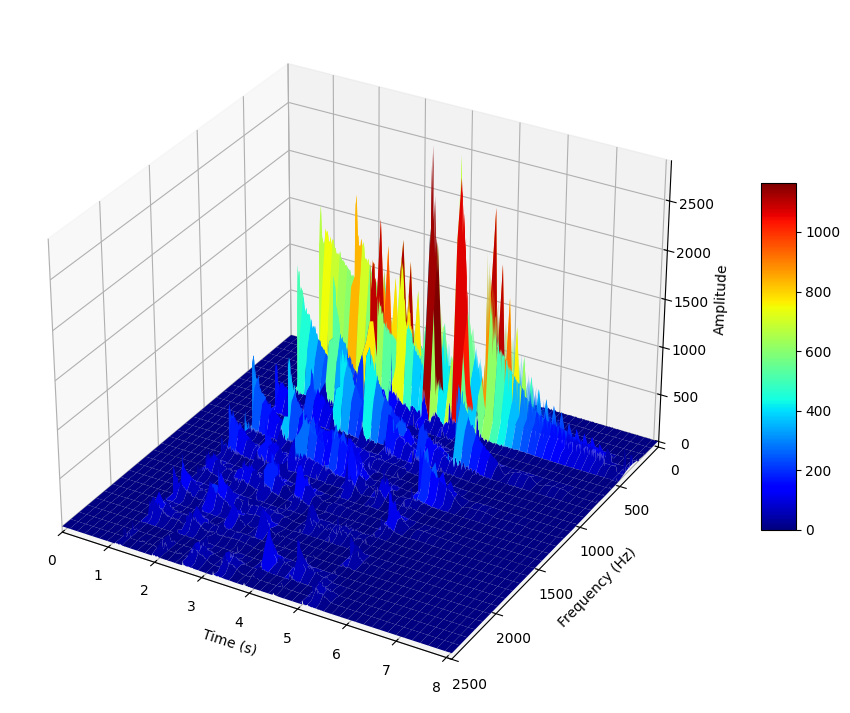

In [95]:
freq_mask = f <= 2500
filtered_freqs = f[freq_mask]
filtered_amplitude = np.abs(Zxx)[freq_mask, :]


fig = plt.figure(figsize=(15, 9))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(*np.meshgrid(t, filtered_freqs), filtered_amplitude, cmap='jet')

ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
ax.set_zlabel('Amplitude')
ax.set_xlim([0, t[-1]])
ax.set_ylim([0, 2500])
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.invert_yaxis()
plt.show()